## Outliers

Outliers are data points that we dont want to consider in our fit. The reasons can be different. It might be spurious signal falling on the detector, like glitches, or in principle valid signal that cannot be considered in the model at hand.

Here we present the same data as in the methanol example. See there for explanation of the construction of the spectrum. 

Part of that spectrum (around 500 GHz) shows a sinusoidal background signal, which is caused by aliasing in the deconvolution process. 

We want to fit the background with a sine function. All absorption lines in the spectrum are outliers and should be disregarded.

In this example we use the NestedSampler with a mixture of 2 error distributions: Gauss and Uniform

Demonstration: 
    1. Compound model of sine + constant
    2. NestedSampler 
    3. MixedErrorDistribution: Gauss + Uniform

Author: Do Kester


We need to import some classes

In [1]:
import numpy as numpy
import math

from astropy.io import fits
from BayesicFitting import SineModel
from BayesicFitting import PolynomialModel
from BayesicFitting import NestedSampler
from BayesicFitting import MixedErrorDistribution
from BayesicFitting import GaussErrorDistribution
from BayesicFitting import UniformErrorDistribution
from BayesicFitting import formatter as fmt
from BayesicFitting import Tools
from BayesicFitting import plotFit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
# uncomment the next line to get the plots in a separate scalable 
# window.

#%matplotlib osx

%matplotlib inline

Read the data

In [3]:
hdu = fits.open( "data/Decgf-Methanol-1-5.fits" )

In [4]:
data = hdu[1].data
flux = data.field( 0 )
freq = data.field( 1 )
covr = data.field( 2 )


Select the part between 490 and 560 GHz, where the background is aliased.

140000


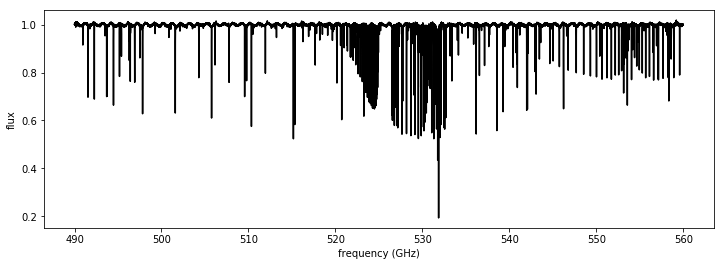

In [5]:
q = numpy.where( numpy.logical_and( freq > 490, freq < 560 ))
flx = flux[q]
frq = freq[q]
cov = covr[q]
print( len( flx ) )
plt.figure( "490 to 560", figsize=(12,4) )
plt.plot( frq, flx, 'k-')
plt.ylabel( "flux" )
plt.xlabel( "frequency (GHz)" )

plt.show()


Make a compound model consisting of a SineModel plus a constant: PolynomialModel( 0 ).

In [6]:
sm = SineModel()
lo = [0.9, -0.2, -0.2]
hi = [1.1, 0.2,  0.2]
sm.setLimits( lo, hi )
pm = PolynomialModel( 0 )
pm.setLimits( [0.99], [1.01] )
model = pm + sm


Construct a mixed error distribution consisting of a Gaussian kernel which should catch the sinusoidal background plus a broad Uniform error distribution that should catch and neutralize the absorption lines.

In [7]:
ged = GaussErrorDistribution( frq, flx, limits=[0.001,1])
ued = UniformErrorDistribution( frq, flx, limits=[0.1,10] )
ed = MixedErrorDistribution( ged, ued, limits=[0,1] )

#Tools.printclass( ed )
#Tools.printclass( ed.hyperpar[0] )
#Tools.printclass( ed.hyperpar[1] )
#Tools.printclass( ed.hyperpar[2] )

ns = NestedSampler( frq, model, flx, distribution=ed, seed=2222 )
ns.verbose = 2

evidence = ns.sample( )
pars = ns.parameters
print( pars )
print( ns.stdevs )
print( ns.scale )
print( evidence )

Fit all parameters of
  Polynomial: f( x:p ) = p_0 +
  Sine: f( x:p ) = p_2 * cos( 2PI * x * p_1 ) + p_3 * sin( 2PI * x * p_1 )
Using a Mixed error distribution : Gauss + Uniform with with unknown hypar
Moving the walkers with   GalileanEngine
Iteration   logZ        H     LowL     npar    parameters
       0 -359677486.0      4.6 -359677481.4      7  [    1.004    0.946    0.096    0.170    0.002 ...]


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/BayesicFitting-1.0.4-py3.5.egg/BayesicFitting/source/MixedErrorDistribution.py:200: RuntimeWarning: divide by zero encountered in true_divide
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/BayesicFitting-1.0.4-py3.5.egg/BayesicFitting/source/MixedErrorDistribution.py:200: RuntimeWarning: overflow encountered in true_divide


     100 -43201.3      5.6 -43195.7      7  [    0.998    1.057    0.059   -0.159    0.298 ...]
     200  50262.7      6.6  50269.3      7  [    1.002    0.905   -0.004   -0.148    0.130 ...]
     300  96852.2      7.6  96859.8      7  [    0.995    0.981    0.067    0.132    0.148 ...]
     400 141918.0      8.6 141926.6      7  [    0.991    1.025    0.046   -0.080    0.089 ...]
     500 178858.8      9.6 178868.4      7  [    0.991    0.918    0.030    0.051    0.081 ...]
     600 217928.8     10.6 217939.4      7  [    1.006    0.964   -0.022   -0.005    0.065 ...]
     700 271275.5     11.6 271287.2      7  [    0.996    1.040   -0.018   -0.008    0.046 ...]
     800 312998.0     12.6 313010.6      7  [    0.993    1.021   -0.001   -0.009    0.009 ...]
     900 342864.6     13.6 342878.2      7  [    0.994    0.910    0.000   -0.003    0.020 ...]
    1000 368784.1     14.6 368798.7      7  [    0.999    0.948    0.006   -0.003    0.018 ...]
    1100 388775.0     15.6 388790.6     

    8700 521666.2     85.9 521753.8      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    8800 521668.3     87.3 521757.1      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    8900 521670.3     88.2 521759.8      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9000 521671.6     88.6 521761.6      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9100 521672.5     89.1 521763.3      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9200 521673.1     89.6 521764.6      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9300 521673.7     90.1 521765.9      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9400 521674.1     90.6 521767.0      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9500 521674.4     91.1 521768.3      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9600 521674.7     91.7 521769.5      7  [    0.999    1.000    0.005    0.001    0.003 ...]
    9700 521675.0     92.3 521770.5     

   17300 521677.0    101.2 521787.1      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   17400 521677.0    101.2 521787.1      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   17500 521677.0    101.2 521787.1      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   17600 521677.0    101.2 521787.1      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   17700 521677.0    101.2 521787.2      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   17800 521677.0    101.2 521787.2      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   17900 521677.0    101.2 521787.2      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   18000 521677.0    101.2 521787.2      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   18100 521677.0    101.2 521787.2      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   18200 521677.0    101.2 521787.2      7  [    0.999    1.000    0.004    0.002    0.003 ...]
   18300 521677.0    101.2 521787.2     

In [8]:
sl = ns.samples
param = sl.parameters
stdev = sl.stdevs
hypar = sl.hypars
sthyp = sl.stdevHypars
print( "Params ", fmt( param, max=None, format=" %10.5f" ) )
print( "Stdevs ", fmt( stdev, max=None, format=" %10.5f" ) )
print( "Hypars ", fmt( hypar, max=None, format=" %10.5f" ) )
print( "StdHyp ", fmt( sthyp, max=None, format=" %10.7f" ) )


Params  [    0.99942    0.99967    0.00434    0.00191]
Stdevs  [    0.00000    0.00003    0.00016    0.00039]
Hypars  [    0.00288    0.80304    0.91305]
StdHyp  [    0.00000    0.00004    0.00094]
[0.00287504 0.80304257 0.91305183]
[4.82896377e-06 4.42923086e-05 9.39072659e-04]


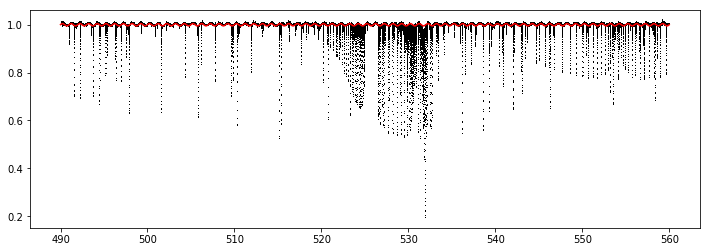

In [9]:
yfit = model.result( frq, param )
plt.figure( 1, figsize=(12,4) )
plt.plot( frq, flx, 'k,' )
plt.plot( frq, yfit, 'r-' )
plt.show()